In [3]:
from matplotlib import pyplot as plt
import cv2
import torch
import torch.nn as nn
import torchvision
import numpy as np
from tqdm.notebook import tqdm

%matplotlib inline

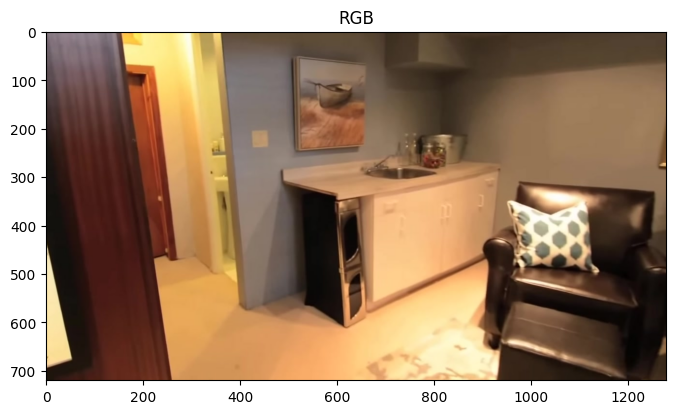

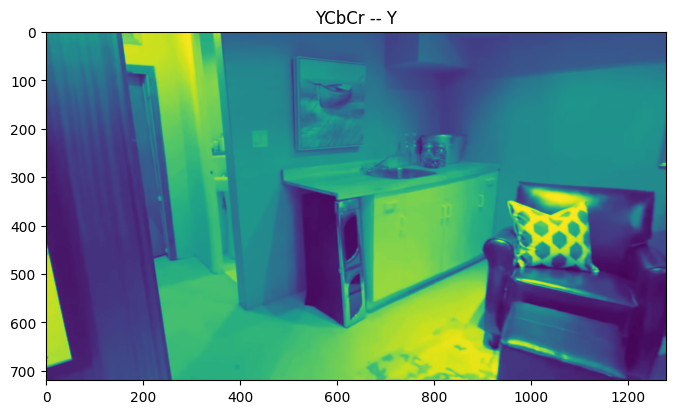

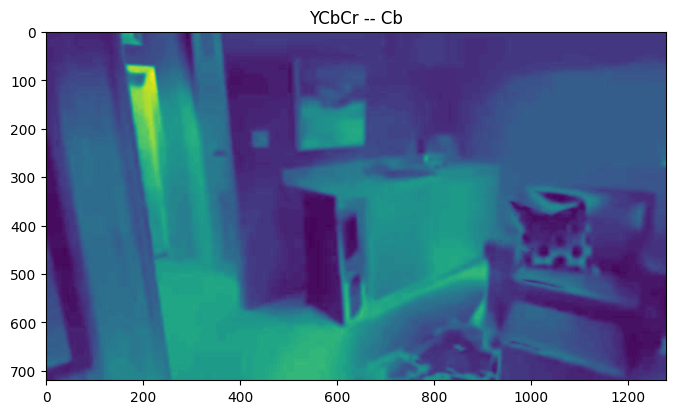

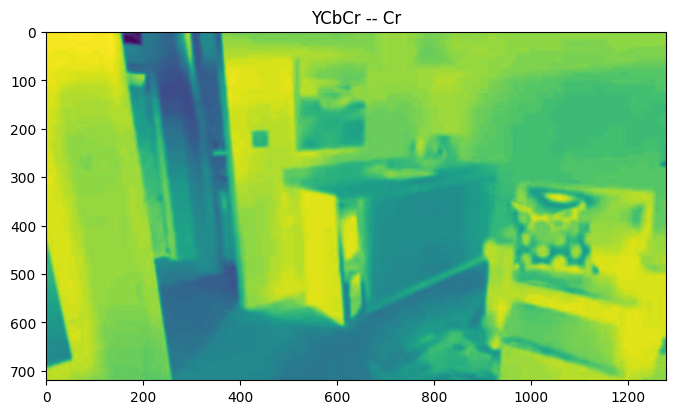

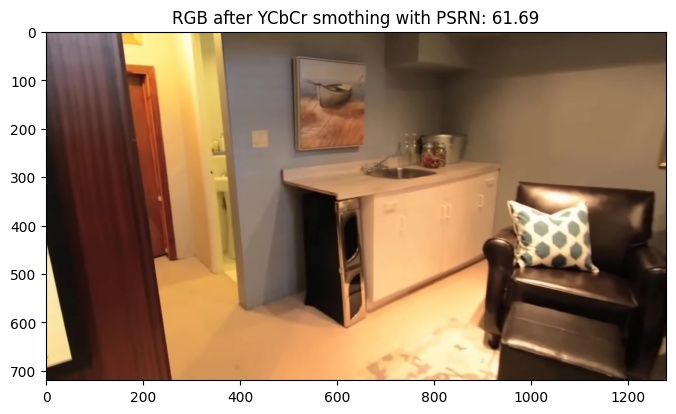

In [5]:
image_path = '/home/alexey/Downloads/-9i5OPoQYBI_170036533_3.png'
img = cv2.cvtColor(cv2.imread(image_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.title('RGB')
plt.imshow(img)

ycbcr_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

# for ch_to_blur in [1, 2]:
#     ycbcr_image[ch_to_blur] = cv2.GaussianBlur(ycbcr_image[ch_to_blur], (5, 5), 1)

for i, channel in zip([0, 1, 2], ['Y', 'Cb', 'Cr']):
    plt.figure(figsize=(8, 6))
    plt.title('YCbCr -- {}'.format(channel))
    plt.imshow(ycbcr_image[..., i])
    
smoothed_rgb = cv2.cvtColor(ycbcr_image, cv2.COLOR_YCrCb2RGB)

plt.figure(figsize=(8, 6))
plt.title('RGB after YCbCr smothing with PSRN: {:.2f}'.format(cv2.PSNR(img, smoothed_rgb)))
plt.imshow(smoothed_rgb)

plt.show()

In [6]:
light_channel = ycbcr_image[..., 0].copy()

In [38]:
def generate_batt(size=(5, 5), d0=5, n=2):
    kernel = np.fromfunction(
        lambda x, y: \
            1 / (1 + (((x - size[0] // 2) ** 2 + (
                    y - size[1] // 2) ** 2) ** 1 / 2) / d0) ** n,
        (size[0], size[1])
    ).astype(np.float32)
    return kernel


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def custom_softmax(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(x))


def custom_swish(x: torch.Tensor) -> torch.Tensor:
    return x * torch.tanh(x)


def real_imaginary_relu(z):
    return nn.functional.relu(z.real) + 1.j * nn.functional.relu(z.imag)


def phase_amplitude_relu(z):
    return nn.functional.relu(torch.abs(z)) * torch.exp(1.j * torch.angle(z))


def real_imaginary_swish(z):
    return nn.functional.silu(z.real) + 1.j * nn.functional.silu(z.imag)


def phase_amplitude_swish(z):
    return nn.functional.silu(torch.abs(z)) * torch.exp(1.j * torch.angle(z))


class FourierComplexConv2d(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, ksize: int, paddings: int = 0, use_bias: bool = True):
        super().__init__()
        
        self.conv_w = nn.Parameter(torch.randn(out_ch, in_ch, ksize, ksize).to(torch.cfloat))
        if use_bias:
            self.conv_b = nn.Parameter(torch.randn(out_ch).to(torch.cfloat))
        else:
            self.conv_b = None
        
        self.paddings = paddings
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return nn.functional.conv2d(
            x,
            self.conv_w,
            self.conv_b,
            padding=self.paddings
        )
    
    
# def conv1x1(inplanes, planes):
#     return FourierComplexConv2d(inplanes, planes, 1, 0)
    
    
# def conv3x3(inplanes, planes):
#     return FourierComplexConv2d(inplanes, planes, 3, 1)


def conv1x1(inplanes, planes):
    return nn.Conv2d(inplanes, planes, 1, padding=0)
    
    
def conv3x3(inplanes, planes):
    return nn.Conv2d(inplanes, planes, 3, padding=1)
    
    
class FourierBlock(nn.Module):
    def __init__(
        self,
        inplanes: int,
        planes: int
    ) -> None:
        super().__init__()
        self.conv1 = conv3x3(inplanes, planes)
        self.conv2 = conv3x3(planes, planes)
        self.upsample_conv = conv1x1(inplanes, planes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = self.upsample_conv(x)

        out = self.conv1(x)
        out = torch.nn.functional.mish(out)

        out = self.conv2(out)

        out += identity
        out = torch.nn.functional.mish(out)

        return out


class FFTCNN(nn.Module):
    def __init__(self, shape, four_normalized=True):
        super().__init__()

        self.four_normalized = 'ortho' if four_normalized else None        
        self.image_shape = shape
        
        self.basic_layer_1 = FourierBlock(3, 16)
        self.basic_layer_2 = FourierBlock(16, 64)
        self.basic_layer_3 = FourierBlock(64, 16)
        self.basic_layer_4 = FourierBlock(16, 3)
        # self.final_conv = FourierComplexConv2d(1, 1, 1, 0, use_bias=False)
        self.final_conv = nn.Conv2d(3, 3, 1, padding=0, bias=False)
            
    def get_fourier(self, x):
        fourier_transform_x = torch.fft.rfft2(
            x, norm=self.four_normalized
        )

        return fourier_transform_x

    def forward(self, image):
        inp = self.get_fourier(image)
        amp_part, angle_part = torch.abs(inp), torch.angle(inp)
        
        x = amp_part
        x = self.basic_layer_1(x)
        x = self.basic_layer_2(x)
        x = self.basic_layer_3(x)
        x = self.basic_layer_4(x)
        x = self.final_conv(x)
        
        x = x * torch.exp(1.j * angle_part)

        restored_x = torch.fft.irfft2(
            x, norm=self.four_normalized
        )

        return restored_x[:, :, :image.size(2), :image.size(3)], inp

tensor(-3.1416)
(4, 3, 720, 1282)


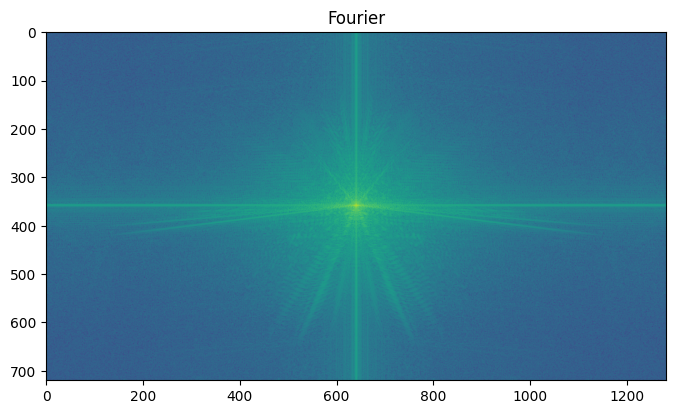

In [76]:
def from_torch_fft_to_np(x: torch.Tensor) -> np.ndarray:
    fshift = x.permute(0, 2, 3, 1).numpy()
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    magnitude_spectrum = np.pad(
        magnitude_spectrum,
        ((0, 0), (0, 0), (x.size(3), 0), (0, 0)),
        mode='reflect'
    )
    magnitude_spectrum[:, :x.size(2) // 2] = magnitude_spectrum[:, :x.size(2) // 2][:, ::-1]
    magnitude_spectrum[:, x.size(2) // 2:] = magnitude_spectrum[:, x.size(2) // 2:][:, ::-1]
    return magnitude_spectrum.transpose(0, 3, 1, 2)


model = FFTCNN(shape=(512, 512))
t = torch.from_numpy(light_channel.astype(np.float32) / 255.0).unsqueeze(0).unsqueeze(0)
t = t.repeat((4, 3, 1, 1))

with torch.no_grad():
    out, fs = model(t)

amp_part, angle_part = torch.abs(fs), torch.angle(fs)

print(angle_part.min())

m = from_torch_fft_to_np(fs)
print(m.shape)
plt.figure(figsize=(8, 6))
plt.title('Fourier')
plt.imshow(m[0, 0])

plt.show()

In [28]:
# optimizer = torch.optim.RAdam(
#     ll_layer.parameters(), lr=0.01,
#     weight_decay=1E-7, 
# )
# scheduler = None

optimizer = torch.optim.SGD(
    ll_layer.parameters(), lr=0.001, 
    weight_decay=1E-7, 
    nesterov=True, momentum=0.9
)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=1.0, cycle_momentum=True)

y = torch_tensor.clone()
x = fourier_repres.clone()

# ploss_model = torchvision.models.vgg11(weights=torchvision.models.vgg.VGG11_Weights.IMAGENET1K_V1)

loss_func = nn.L1Loss()
ploss_func = nn.BCEWithLogitsLoss()

# N = 30000
N = 10
with tqdm(total=N) as pbar:
    for batch_i in range(N):
        optimizer.zero_grad()
        new_y = ll_layer(x)
        
        loss = loss_func(new_y, y)
        
#         if (batch_i + 1) % 10 == 0:
#             pout_1 = ploss_model(new_y.repeat(1, 3, 1, 1))
#             pout_2 = ploss_model(y.repeat(1, 3, 1, 1))
#             loss += ploss_func(pout_1, pout_2)
        
        loss.backward()
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
        
        pbar.postfix = \
        'Loss: {:.5f}, lr: {:.7f}'.format(
            loss.item(),
            get_lr(optimizer)
        )
        pbar.update(1)

  0%|          | 0/10 [00:00<?, ?it/s]

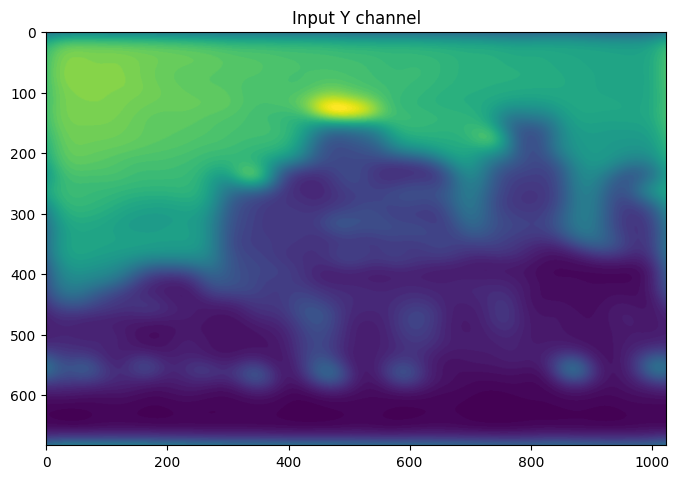

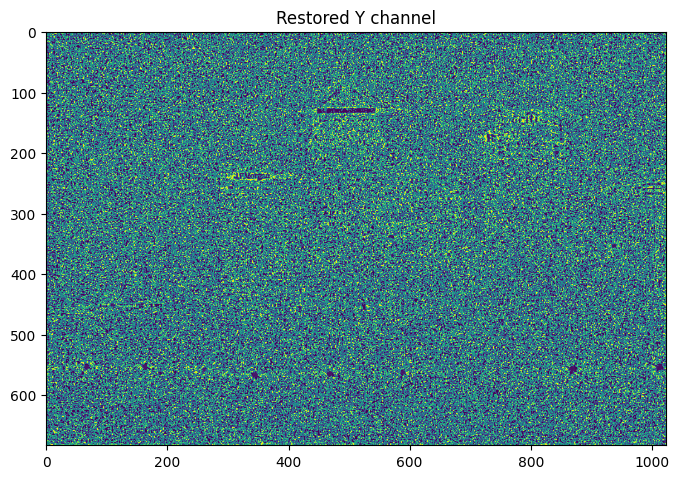

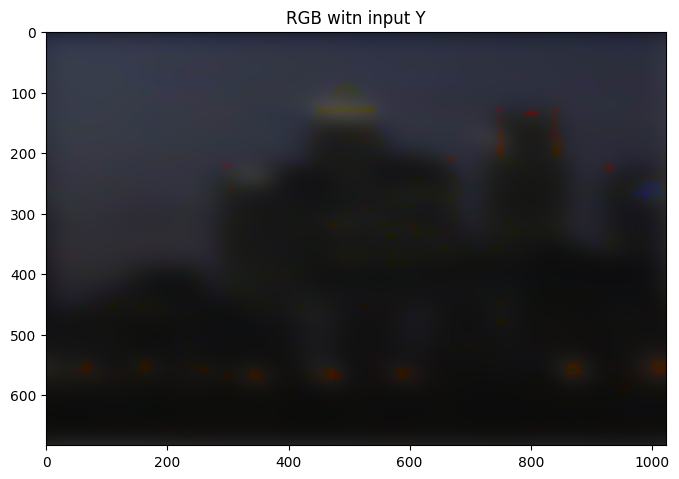

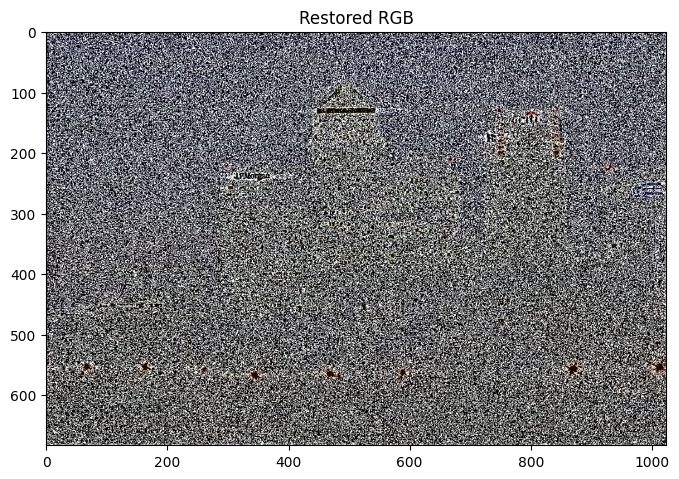

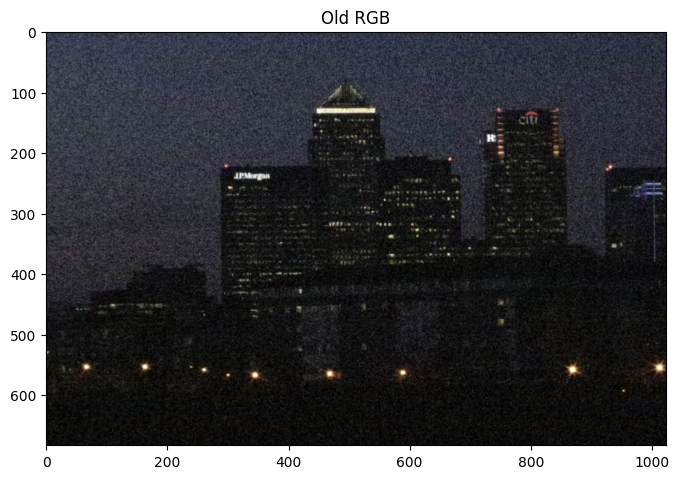

In [27]:
llf_image = ll_layer(fourier_repres)

plt.figure(figsize=(8, 6))
plt.title('Input Y channel')
plt.imshow(raw_blurred_image)

plt.figure(figsize=(8, 6))
plt.title('Restored Y channel')
plt.imshow((llf_image.detach().to('cpu').numpy()[0, 0] * 255.0).astype(np.uint8))

new_ycbcr_image = ycbcr_image.copy()
new_ycbcr_image[..., 0] = (llf_image.to('cpu').detach().numpy()[0, 0] * 255.0).astype(np.uint8)
new_rgb = cv2.cvtColor(new_ycbcr_image, cv2.COLOR_YCrCb2RGB)


new_ycbcr_image[..., 0] = raw_blurred_image
input_y_rgb = cv2.cvtColor(new_ycbcr_image, cv2.COLOR_YCrCb2RGB)
plt.figure(figsize=(8, 6))
plt.title('RGB witn input Y')
plt.imshow(input_y_rgb)

plt.figure(figsize=(8, 6))
plt.title('Restored RGB')
plt.imshow(new_rgb)

plt.figure(figsize=(8, 6))
plt.title('Old RGB')
plt.imshow(img)

plt.show()